<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/OpenMined/PipelineDP/blob/main/examples/conference.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/OpenMined/PipelineDP/blob/main/examples/conference.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

This is a simple example that shows how to calculate anonymized statistics using PipelineDP. The input data is a simulated dataset of an imaginary conference participants including their origin coutries. We use PipelineDP to calculate anonymized count of participants aggregated by country.

# Install dependencies and download data


In [1]:
#@markdown Install dependencies and download data

!pip install pipeline-dp apache_beam

from IPython.display import clear_output
clear_output()
import pipeline_dp
import numpy as np
import matplotlib.pyplot as plt

# Construct and inspect the input data

Below we construct the input dataset.

In [2]:
#@markdown Construct the input data
# The format of the input is: (participant_id, country).
# Participants u_0...u_49 come from Germany, participants u_50...u_149 come from
# Switzerland, etc.
input = [(f"{u}", "Germany") for u in range(50)]
input += [(f"{u + 50}", "Switzerland") for u in range(75)]
input += [(f"{u + 125}", "France") for u in range(30)]
input += [(f"{u + 155}", "Italy") for u in range(40)]
input += [(f"{u + 195}", "UK") for u in range(100)]

The goal of this Colab is to demonstrate how to compute the count of participants aggregated by country in a DP manner.

The plot below demonstrates the non-private result.

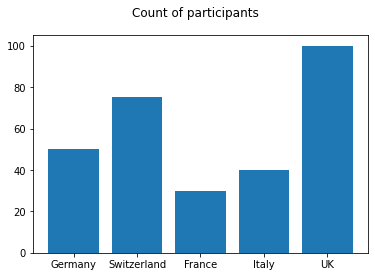

In [3]:
#@title Non-private statistics
countries = ["Germany", "Switzerland", "France", "Italy", "UK"]
non_dp_count = [0] * len(countries)
for participant_info in input:
  country = participant_info[1]
  index = countries.index(country)
  non_dp_count[index] = non_dp_count[index] + 1

plt.bar(countries, non_dp_count)
plt.suptitle('Count of participants')
plt.show()


# Run DP pipeline
Below we compute the same statistics using differential privacy and PipelineDP.

In [4]:
#@title DP statistics

# Choose the backend: local, Beam or Spark
backend = pipeline_dp.LocalBackend()

# Define the total privacy loss that can be introduced by this pipeline
budget_accountant = pipeline_dp.NaiveBudgetAccountant(total_epsilon=1, total_delta=1e-6)

# Create DPEngine
dp_engine = pipeline_dp.DPEngine(budget_accountant, backend)

# Configure functions to extract partition key, privacy ID and aggregated value
# from the input data
data_extractors = pipeline_dp.DataExtractors(
   partition_extractor=lambda row: row[1],
   privacy_id_extractor=lambda row: row[0],
   value_extractor=lambda row: 1)

# Configure the aggregation parameters
params = pipeline_dp.AggregateParams(
   noise_kind=pipeline_dp.NoiseKind.LAPLACE,
   metrics=[pipeline_dp.Metrics.PRIVACY_ID_COUNT],
   max_partitions_contributed=1,
   max_contributions_per_partition=1,
   min_value=0,
   max_value=1)

# Create a computational graph for the aggregation.
# All computations are lazy. dp_result is iterable, but iterating it would
# fail until budget is computed (below).
# It’s possible to call DPEngine.aggregate multiple times with different
# metrics to compute.
dp_result = dp_engine.aggregate(input, params, data_extractors)

# Compute budget per each DP operation. 
budget_accountant.compute_budgets()

# Here's where the lazy iterator initiates computations and gets transformed
# into actual results
dp_result = list(dp_result)
print(dp_result)

[('Germany', MetricsTuple(privacy_id_count=49.10272994384104)), ('Switzerland', MetricsTuple(privacy_id_count=75.26271629976691)), ('France', MetricsTuple(privacy_id_count=32.206397102141636)), ('Italy', MetricsTuple(privacy_id_count=37.134226348807715)), ('UK', MetricsTuple(privacy_id_count=97.95130274764233))]


# Inspect the result

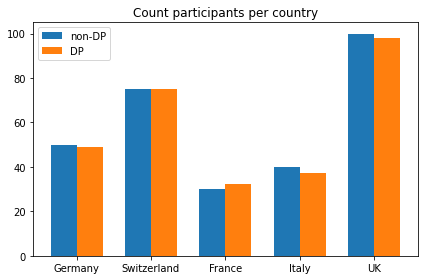

In [5]:
#@markdown ##Inspect the result
#@markdown Below you can see the DP and non-DP results.

dp_count = [0] * len(countries)
for i, dp_count_per_country in enumerate(dp_result):
  dp_count[i] = dp_count_per_country[1][0]


x = np.arange(len(countries))

width = 0.35
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, non_dp_count, width, label='non-DP')
rects2 = ax.bar(x + width/2, dp_count, width, label='DP')
ax.set_title('Count participants per country')
ax.set_xticks(x)
ax.set_xticklabels(countries)
ax.legend()
fig.tight_layout()
plt.savefig("chart.png")
plt.show()
